In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import datetime
from cuml import ForestInference
import sys
from tqdm import tqdm
import os
import random

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle')
from utils.xgb import fit_xgb, inference_xgb
from utils.metric import compute_comptetition_metric

In [2]:
config = f"""
execution:
    exp_id: exp_001
    debug: False
    submit: False

dataset: 
    competition_dir: /kaggle/input/child-mind-institute-detect-sleep-states
    cv_split_path: /kaggle/input/cv_split/train_folds.csv
    train_base_path: /kaggle/input/train_base/train_base.csv
    day_csv_dir: /kaggle/input/save_day_csv/day_csvs

xgboost:    
    objective: "reg:squarederror"
    learning_rate: 0.01  # 0.01で固定。学習時間とのトレードオフ
    reg_alpha: 0.02  # L1正則化。0.1が推奨。
    reg_lambda: 0.2  # L2正則化。0.1が推奨
    random_state: 42
    max_depth: 5  # 3-8。7くらいでいい。
    colsample_bytree: 0.7  # カラムが多い時は少なめ(0.4とか)にする。
    
seed: 46
"""

CFG = yaml.load(config, Loader=yaml.SafeLoader)

CFG["output_dir"] = f"/kaggle/output/{CFG['execution']['exp_id']}"
os.makedirs(CFG["output_dir"], exist_ok=True)

In [3]:
# base df
train_base = pd.read_csv(CFG['dataset']['train_base_path'])
train_base["start_time"] = pd.to_datetime(train_base["start_time"], utc=True)
train_base["end_time"] = pd.to_datetime(train_base["end_time"], utc=True)

# cv split
cv_split = pd.read_csv(CFG['dataset']['cv_split_path'])
train_base = train_base.merge(cv_split, on="series_id", how="left")

# label
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna().reset_index(drop=True)

# デバッグ時はデータ数を減らす
if CFG['execution']['debug']:
    sample_series_id = random.sample(list(train_base["series_id"].unique()), 20)
    train_base = train_base[train_base["series_id"].isin(sample_series_id)].reset_index(drop=True)
    labels = labels[labels["series_id"].isin(sample_series_id)].reset_index(drop=True)

# 目的変数の欠損は平均値で埋める(TODO: ここは分類問題で弾く)
train_base["target"] = train_base["target"].fillna(train_base["target"].mean())

train_base.head()

,series_id,start_time,end_time,target_type,target_step,target_timestamp,sample_id,target,fold
0,038441c925bb,2018-08-13 23:00:00+00:00,2018-08-14 22:59:59+00:00,wakeup,NaN,NaN,0,9299.177207,2
1,038441c925bb,2018-08-14 23:00:00+00:00,2018-08-15 22:59:59+00:00,wakeup,10932.0,2018-08-15 10:41:00+00:00,1,8412.000000,2
2,038441c925bb,2018-08-15 23:00:00+00:00,2018-08-16 22:59:59+00:00,wakeup,27492.0,2018-08-16 09:41:00+00:00,2,7692.000000,2
3,038441c925bb,2018-08-16 23:00:00+00:00,2018-08-17 22:59:59+00:00,wakeup,44400.0,2018-08-17 09:10:00+00:00,3,7320.000000,2
4,038441c925bb,2018-08-17 23:00:00+00:00,2018-08-18 22:59:59+00:00,wakeup,62856.0,2018-08-18 10:48:00+00:00,4,8496.000000,2


In [4]:
def add_step_features(train: pd.DataFrame, features: dict):
    # 開始時刻のギャップ
    features["step_diff_start"] = (pd.to_datetime(train["timestamp"][0]) - pd.to_datetime(train["start_time"][0])).total_seconds() // 5

    # 終了時刻のギャップ
    features["step_diff_end"] = (pd.to_datetime(train["end_time"].values[-1]) - pd.to_datetime(train["timestamp"].values[-1])).total_seconds() // 5

    # stepを統一する
    train = train.reset_index(drop=True)
    train["step"] = features["step_diff_start"] + train.index

    # 全ステップ数
    features["step_duration"] = train["step"].max() - train["step"].min() + 1
    return train, features


def add_sensor_sampling_features(train: pd.DataFrame, features: dict):
    # 30分ごとのセンサデータの統計量
    train["segment_id"] = train["step"] // (30 * 60 // 5) # 30min * 60sec / 5sec [step]
    for c in ["anglez", "enmo"]:
        df = train.groupby("segment_id")[c].agg(["mean", "std", "min", "max"]).reset_index().add_prefix(f"{c}_")
        df = df.sort_values(f'{c}_segment_id').reset_index(drop=True)
        df[f'{c}_segment_id'] = df[f'{c}_segment_id'].astype(int).apply(lambda x: f"{x:04d}")

        # # lag features
        # dts = [-3, -2, -1, 1, 2, 3]
        # columns = [f"{c}_std"]
        # for dt in dts:
        #     f_names = [f"{c}_diff_{dt}" for c in columns]
        #     df[f_names] = df[columns].diff(dt)

        df.set_index(f'{c}_segment_id', inplace=True)
        result_dict = df.to_dict(orient='index')
        features |= {f"{col}_segid_{idx}": value for idx, row in result_dict.items() for col, value in row.items()}
    return train, features

In [5]:
def generate_features(train: pd.DataFrame):
    features = {}
    if train.shape[0] == 0:
        return train, features
    
    # wakeup or onset
    features["for_wakeup"] = float(train["target_type"].values[0] == "wakeup")

    features["global_start_time"] = train["global_start_time"].values[0]
    train, features = add_step_features(train, features)
    train, features = add_sensor_sampling_features(train, features)
    return train, features


In [6]:
dfs = []
all_features = []
for series_id, sample_id in tqdm(train_base[["series_id", "sample_id"]].values):
    train = pd.read_csv(f"{CFG['dataset']['day_csv_dir']}/{series_id}/{sample_id}.csv")
    train, features = generate_features(train)

    features["series_id"] = series_id
    features["sample_id"] = sample_id

    dfs.append(train)
    all_features.append(features)


  0%|          | 0/15406 [00:00<?, ?it/s]

100%|██████████| 15406/15406 [06:14<00:00, 41.09it/s]


In [7]:
features = set().union(*[d.keys() for d in all_features]) - {"series_id", "sample_id", "global_start_time"}
train = pd.DataFrame(all_features)

# cv splitとマージ
train = train_base.merge(train, on=["series_id", "sample_id"], how="left")
train.head(5)

,series_id,start_time,end_time,target_type,target_step,target_timestamp,sample_id,target,fold,for_wakeup,...,enmo_min_segid_0038,enmo_max_segid_0038,enmo_mean_segid_0039,enmo_std_segid_0039,enmo_min_segid_0039,enmo_max_segid_0039,enmo_mean_segid_0040,enmo_std_segid_0040,enmo_min_segid_0040,enmo_max_segid_0040
0,038441c925bb,2018-08-13 23:00:00+00:00,2018-08-14 22:59:59+00:00,wakeup,NaN,NaN,0,9299.177207,2,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,038441c925bb,2018-08-14 23:00:00+00:00,2018-08-15 22:59:59+00:00,wakeup,10932.0,2018-08-15 10:41:00+00:00,1,8412.000000,2,1.0,...,0.0,0.5504,0.035178,0.041762,0.0,0.2823,0.038151,0.078651,0.0,0.9494
2,038441c925bb,2018-08-15 23:00:00+00:00,2018-08-16 22:59:59+00:00,wakeup,27492.0,2018-08-16 09:41:00+00:00,2,7692.000000,2,1.0,...,0.0,0.9803,0.072729,0.098188,0.0,0.9207,0.021324,0.064757,0.0,0.7314
3,038441c925bb,2018-08-16 23:00:00+00:00,2018-08-17 22:59:59+00:00,wakeup,44400.0,2018-08-17 09:10:00+00:00,3,7320.000000,2,1.0,...,0.0,1.3254,0.060363,0.100459,0.0,0.7389,0.041960,0.091901,0.0,1.0855
4,038441c925bb,2018-08-17 23:00:00+00:00,2018-08-18 22:59:59+00:00,wakeup,62856.0,2018-08-18 10:48:00+00:00,4,8496.000000,2,1.0,...,0.0,0.5337,0.029186,0.050756,0.0,0.4811,0.030269,0.029380,0.0,0.2505


In [8]:
if CFG['execution']['submit']:
    # 推論
    models = [
        ForestInference.load(
            os.path.join(CFG["model_dir"], f'xgb_fold{i}.model'),
            output_class=True,
            model_type='xgboost'
        ) for i in range(CFG.n_fold)]
    pred = inference_xgb(models, train[features])
else:
    # 学習
    trn_oof, models = fit_xgb(train[features], train["target"], train["fold"].astype(
        int), params=CFG["xgboost"], es_rounds=50)
    train["oof"] = trn_oof

    # 保存
    for i, model in enumerate(models):
        model.save_model(os.path.join(CFG["output_dir"], f'xgb_fold{i}.model'))

  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[0]	eval-rmse:9184.44192
[50]	eval-rmse:5569.28435
[100]	eval-rmse:3398.74863
[150]	eval-rmse:2108.21779
[200]	eval-rmse:1366.32063
[250]	eval-rmse:965.54990
[300]	eval-rmse:773.87783
[350]	eval-rmse:693.15959
[400]	eval-rmse:664.08452
[450]	eval-rmse:655.18615
[500]	eval-rmse:652.48820
[550]	eval-rmse:651.45323
[600]	eval-rmse:650.78079
[650]	eval-rmse:650.06225
[700]	eval-rmse:649.62285
[750]	eval-rmse:648.84582
[796]	eval-rmse:649.01675


 20%|██        | 1/5 [00:17<01:08, 17.20s/it]

== fold 1 ==
[0]	eval-rmse:9226.86099
[50]	eval-rmse:5619.55507
[100]	eval-rmse:3451.89827
[150]	eval-rmse:2160.21840
[200]	eval-rmse:1411.68981
[250]	eval-rmse:1000.56626
[300]	eval-rmse:793.94037
[350]	eval-rmse:702.96563
[400]	eval-rmse:665.86025
[450]	eval-rmse:650.15233
[500]	eval-rmse:643.24638
[550]	eval-rmse:640.48135
[600]	eval-rmse:638.92396
[650]	eval-rmse:638.27331
[700]	eval-rmse:637.37719
[750]	eval-rmse:636.63465
[800]	eval-rmse:635.73591
[850]	eval-rmse:635.15403
[900]	eval-rmse:634.42771
[950]	eval-rmse:633.80978
[1000]	eval-rmse:633.60371
[1050]	eval-rmse:633.24988
[1100]	eval-rmse:632.46029
[1150]	eval-rmse:632.00143
[1200]	eval-rmse:631.56495
[1250]	eval-rmse:631.24514
[1300]	eval-rmse:630.82052
[1350]	eval-rmse:630.24852
[1400]	eval-rmse:629.91779
[1450]	eval-rmse:629.74266
[1500]	eval-rmse:629.53602
[1550]	eval-rmse:629.00052
[1600]	eval-rmse:628.57351
[1650]	eval-rmse:627.85749
[1700]	eval-rmse:627.47305
[1742]	eval-rmse:627.58256


 40%|████      | 2/5 [00:52<01:23, 27.88s/it]

== fold 2 ==
[0]	eval-rmse:9178.09826
[50]	eval-rmse:5552.60882
[100]	eval-rmse:3377.26134
[150]	eval-rmse:2091.76556
[200]	eval-rmse:1360.30731
[250]	eval-rmse:978.31452
[300]	eval-rmse:807.36058
[350]	eval-rmse:745.30739
[400]	eval-rmse:726.66735
[450]	eval-rmse:723.25721
[500]	eval-rmse:724.17805
[504]	eval-rmse:724.18595


 60%|██████    | 3/5 [01:03<00:40, 20.06s/it]

== fold 3 ==
[0]	eval-rmse:9435.38877
[50]	eval-rmse:5810.02668
[100]	eval-rmse:3624.12991
[150]	eval-rmse:2319.59562
[200]	eval-rmse:1565.69862
[250]	eval-rmse:1146.76578
[300]	eval-rmse:939.75463
[350]	eval-rmse:844.24912
[400]	eval-rmse:800.33365
[450]	eval-rmse:778.24205
[500]	eval-rmse:767.04624
[550]	eval-rmse:761.54887
[600]	eval-rmse:757.86892
[650]	eval-rmse:755.15704
[700]	eval-rmse:753.35568
[750]	eval-rmse:752.05394
[800]	eval-rmse:750.68690
[850]	eval-rmse:749.95030
[900]	eval-rmse:748.64379
[950]	eval-rmse:747.77239
[1000]	eval-rmse:747.10911
[1050]	eval-rmse:746.73904
[1100]	eval-rmse:746.45573
[1150]	eval-rmse:746.10259
[1200]	eval-rmse:745.52466
[1250]	eval-rmse:745.10416
[1300]	eval-rmse:744.92105
[1350]	eval-rmse:744.06205
[1400]	eval-rmse:743.86316
[1421]	eval-rmse:743.81296


 80%|████████  | 4/5 [01:34<00:24, 24.62s/it]

== fold 4 ==
[0]	eval-rmse:9301.75585
[50]	eval-rmse:5684.52422
[100]	eval-rmse:3513.81152
[150]	eval-rmse:2227.61540
[200]	eval-rmse:1488.71770
[250]	eval-rmse:1094.41047
[300]	eval-rmse:903.78163
[350]	eval-rmse:820.71817
[400]	eval-rmse:785.94585
[450]	eval-rmse:771.80449
[500]	eval-rmse:765.61350
[550]	eval-rmse:762.91963
[600]	eval-rmse:761.63088
[650]	eval-rmse:760.51944
[700]	eval-rmse:759.93285
[750]	eval-rmse:759.28998
[800]	eval-rmse:759.21108
[850]	eval-rmse:758.73507
[900]	eval-rmse:758.48864
[950]	eval-rmse:757.84505
[1000]	eval-rmse:757.59735
[1050]	eval-rmse:757.46375
[1062]	eval-rmse:757.50222


100%|██████████| 5/5 [01:58<00:00, 23.75s/it]


In [9]:
train = train.drop(columns=features)

In [10]:
train

,series_id,start_time,end_time,target_type,target_step,target_timestamp,sample_id,target,fold,global_start_time,oof
0,038441c925bb,2018-08-13 23:00:00+00:00,2018-08-14 22:59:59+00:00,wakeup,NaN,NaN,0,9299.177207,2,2018-08-14 19:30:00+00:00,9198.260742
1,038441c925bb,2018-08-14 23:00:00+00:00,2018-08-15 22:59:59+00:00,wakeup,10932.0,2018-08-15 10:41:00+00:00,1,8412.000000,2,2018-08-14 19:30:00+00:00,8721.470703
2,038441c925bb,2018-08-15 23:00:00+00:00,2018-08-16 22:59:59+00:00,wakeup,27492.0,2018-08-16 09:41:00+00:00,2,7692.000000,2,2018-08-14 19:30:00+00:00,9380.016602
3,038441c925bb,2018-08-16 23:00:00+00:00,2018-08-17 22:59:59+00:00,wakeup,44400.0,2018-08-17 09:10:00+00:00,3,7320.000000,2,2018-08-14 19:30:00+00:00,8517.327148
4,038441c925bb,2018-08-17 23:00:00+00:00,2018-08-18 22:59:59+00:00,wakeup,62856.0,2018-08-18 10:48:00+00:00,4,8496.000000,2,2018-08-14 19:30:00+00:00,9415.028320
...,...,...,...,...,...,...,...,...,...,...,...
15401,fe90110788d2,2017-09-04 14:00:00+00:00,2017-09-05 13:59:59+00:00,onset,538956.0,2017-09-05 02:03:00+00:00,15401,8676.000000,2,2017-08-04 21:30:00+00:00,8946.682617
15402,fe90110788d2,2017-09-05 14:00:00+00:00,2017-09-06 13:59:59+00:00,onset,556560.0,2017-09-06 02:30:00+00:00,15402,9000.000000,2,2017-08-04 21:30:00+00:00,9145.316406
15403,fe90110788d2,2017-09-06 14:00:00+00:00,2017-09-07 13:59:59+00:00,onset,574620.0,2017-09-07 03:35:00+00:00,15403,9780.000000,2,2017-08-04 21:30:00+00:00,9744.101562
15404,fe90110788d2,2017-09-07 14:00:00+00:00,2017-09-08 13:59:59+00:00,onset,NaN,NaN,15404,9299.177207,2,2017-08-04 21:30:00+00:00,9503.957031


In [11]:
train = train.dropna(subset=["global_start_time"]).reset_index(drop=True)

In [12]:
train["pred_timestamp"] = pd.to_datetime(train["start_time"]) + pd.to_timedelta(train["oof"] * 5, unit="s")
train = train.dropna()

train["step"] = (train["pred_timestamp"] - pd.to_datetime(train["global_start_time"])).dt.total_seconds() // 5
train["score"] = 1
train["event"] = train["target_type"]

In [13]:
score, ap_table = compute_comptetition_metric(labels, train)
score

0.12651419265452832

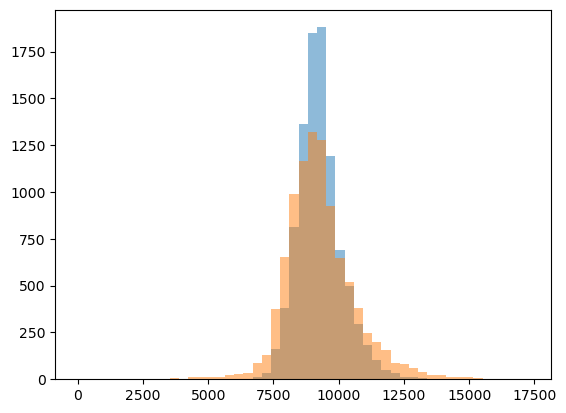

In [14]:
plt.hist(train["oof"], bins=np.linspace(0, 60 * 60 * 24 // 5, 50), alpha=0.5)
plt.hist(train["target"], bins=np.linspace(0, 60 * 60 * 24 // 5, 50), alpha=0.5)
plt.show()